# YOLO Inference

In [16]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob

In [17]:
# 資料夾路徑
img_train = r'acne2noacne/trainA'
img_test = r'acne2noacne/testA'

to_path_train = img_train + '_label'
if not os.path.exists(to_path_train):
    os.makedirs(to_path_train)
    
to_path_test = img_test + '_label'
if not os.path.exists(to_path_test):
    os.makedirs(to_path_test)    

from_path_train = glob.glob(img_train + r'/*.jpg', recursive=True)
from_path_test = glob.glob(img_test + r'/*.jpg', recursive=True)
print(len(from_path_train))
print(len(from_path_test))


# img_test = r'test20_image'
# to_path_test = img_test + '_label'

# if not os.path.exists(to_path_test):
#     os.makedirs(to_path_test)    

# from_path_test = glob.glob(img_test + r'/*.jpg', recursive=True)
# print(len(from_path_test))


719
80


### 1. 使用YOLO為資料夾內所有照片做inference，並生成後續inpainting, filter等處理所需的mask與bounding box

In [4]:
model = YOLO('train11/weights/best.pt') 

# # inference 單張照片
# results = model.predict("acne2noacne/trainA/levle0_1.jpg", conf=0.2, save=True)

In [18]:
# 將YOLO標記資料轉為dataframe
def yoloinf(img_path, conf=0.1):
    results = model.predict(img_path, conf=conf, save=True)
    boxes = results[0].boxes.xywhn
    confs = results[0].boxes.conf
    # the results will be saved in runs/detect/detect
    
    boxes_confs = [{"x": float(box[0]), "y": float(box[1]), 
                    "width": float(box[2]), "height": float(box[3]), 
                    "conf": float(conf)} for box, conf in zip(boxes, confs)]
    df = pd.DataFrame(boxes_confs)
    
    return boxes_confs, df 

In [19]:
def labeltxt(from_path, to_path):    
    for fname in from_path:
        _, boxes_confs = yoloinf(fname, conf=0)
        label_fname = to_path + "/" + fname.split('/')[-1].split(".")[:-1][0]+".txt"
        with open(label_fname, 'w') as f:
            f.write(boxes_confs.to_csv(index=False, sep=' '))

    fnames = glob.glob(to_path + r'/*.txt', recursive=False)
    print(f'save {len(fnames)} txx label file to {to_path}')

In [20]:
# labeltxt(from_path_train , to_path_train)
labeltxt(from_path_test , to_path_test)


image 1/1 /Users/liang/Documents/NCKU_DS/DL/YOLO/acne2noacne/testA/levle1_377.jpg: 640x640 127 acnes, 1 mole1, 3 pimples, 10 scars, 159 spots, 117.7ms
Speed: 2.8ms preprocess, 117.7ms inference, 128.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict

image 1/1 /Users/liang/Documents/NCKU_DS/DL/YOLO/acne2noacne/testA/levle1_33.jpg: 640x640 160 acnes, 10 mole1s, 9 pimples, 4 scars, 117 spots, 108.4ms
Speed: 2.2ms preprocess, 108.4ms inference, 118.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict

image 1/1 /Users/liang/Documents/NCKU_DS/DL/YOLO/acne2noacne/testA/levle1_203.jpg: 640x640 183 acnes, 7 pimples, 6 scars, 104 spots, 107.7ms
Speed: 2.5ms preprocess, 107.7ms inference, 126.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict

image 1/1 /Users/liang/Documents/NCKU_DS/DL/YOLO/acne2noacne/testA/levle1_216.jpg: 640x640 107 acnes, 8 mole1s, 1 mole2, 22 pimples, 2 scars, 

### 3. 將 YOLO 找出標記位置轉為0, 1組成的 Acne Feature Map

In [21]:
# 起點在左上
def convert2map(data, img_size=(640, 640)):
    
    mask = np.zeros(img_size, dtype=int)
    img_width, img_height = img_size

    # 填充目標區域
    for prediction in data:
        x_center = prediction["x"] * img_width
        y_center = prediction["y"] * img_height
        width = prediction["width"] * img_width
        height = prediction["height"] * img_height

        # 計算左上, 右下座標
        x_start = max(0, int(x_center - width / 2))
        x_end = min(img_width, int(x_center + width / 2))
        y_start = max(0, int(y_center - height / 2))
        y_end = min(img_height, int(y_center + height / 2))

        # 在目標區域內填充 1
        mask[y_start:y_end, x_start:x_end] = 1
    
    return mask


image 1/1 /Users/liang/Documents/NCKU_DS/DL/YOLO/acne2noacne/testA/levle1_16.jpg: 640x640 2 acnes, 6 mole1s, 62 spots, 122.6ms
Speed: 2.9ms preprocess, 122.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


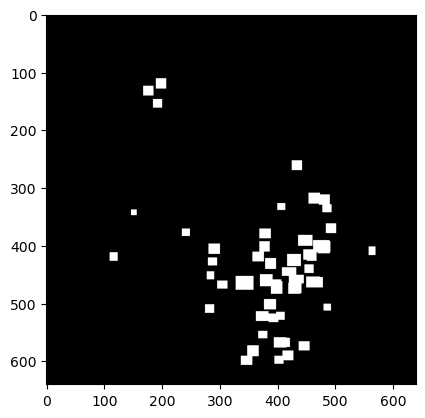

In [22]:
boxes_dicts,_ = yoloinf('acne2noacne/testA/levle1_16.jpg')
mask = convert2map(boxes_dicts, (640, 640))
plt.imshow(mask, cmap='gray')
plt.show()